Hybrid Forex prediction model using multiple regression, simulated annealing, reinforcement learning and technical analysis

https://www.researchgate.net/profile/Chihab-Younes/publication/366165718_Hybrid_Forex_prediction_model_using_multiple_regression_simulated_annealing_reinforcement_learning_and_technical_analysis/links/6393e9e0e42faa7e75aefbac/Hybrid-Forex-prediction-model-using-multiple-regression-simulated-annealing-reinforcement-learning-and-technical-analysis.pdf?origin=publication_detail

In [88]:
# Libraries and Modules used
import MetaTrader5 as mt5 
import pandas as pd
from sklearn.linear_model import LinearRegression
import ta
import warnings
warnings.filterwarnings("ignore")
import numpy as np
# warnings.filterwarnings("ignore")
mt5.initialize()
# Replace following with your MT5 Account Login
account=51127988 # 
password="Aar2frM7"
server = 'ICMarkets-Demo'

In [89]:
# Function to get rates from MT5 
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1

## Backtesting 

In [90]:
# Code to get X Variables 
EURUSD = get_rates('AUDUSD.a', mt5.TIMEFRAME_D1, 1000)
EURUSD = EURUSD[['close']]
# Gets the last 6 closes of chosen timeframe. If you chose daily tf, it'll get last 6 days. If 4 hour, it'll get last
# 6 4 hour candles etc etc. 
for i in range(1,7):
    EURUSD[f'Period {i}'] = EURUSD['close'].shift(i)

# Gets 2 week and 1 month averages 
EURUSD['2w'] = EURUSD['close'].rolling(window = 14).mean()
EURUSD['1m'] = EURUSD['close'].rolling(window = 30).mean()

# Added an RSI as a variable 
EURUSD['rsi'] = ta.momentum.rsi(EURUSD['close'], window = 14, fillna = False)

EURUSD = EURUSD.dropna()

In [91]:
EU_x = EURUSD
EU_x = EU_x.drop('close', axis = 1)

In [92]:
# Defining X (features) and y (target)
X = EU_x
X = X.dropna()
y = EURUSD['close']

In [93]:
##Define the model
from sklearn.linear_model import LinearRegression
# Create and train the model (replace with your actual training code)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

<AxesSubplot:>

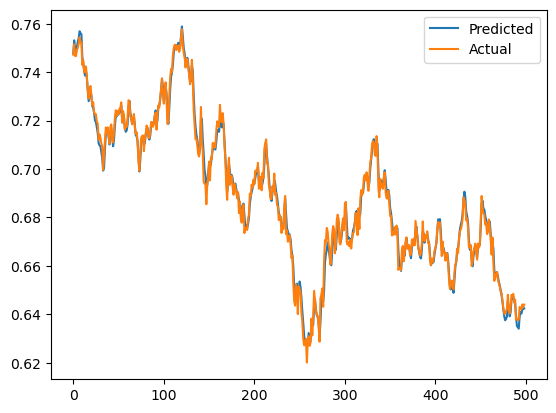

In [94]:
vals = pd.DataFrame()  # Create an empty DataFrame to put the following code into. 

for i in range(1, 500):  
    today_features = X.iloc[-i]
    today_price = model.predict([today_features])[0]
    
    vals = vals.append({'Predicted': today_price, 'Actual': EURUSD['close'].iloc[-i]}, ignore_index=True)

vals = vals[::-1].reset_index(drop=True)  # Reverse the order to match the original sequence
vals.plot()

## Predicting 

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Code to get X Variables 
EURUSD = get_rates('AUDUSD.a', mt5.TIMEFRAME_D1, 500)
EURUSD = EURUSD[['close']]

# Getting lags and rolling averages
for i in range(1,7):
    EURUSD[f'Period {i}'] = EURUSD['close'].shift(i)
EURUSD['2w'] = EURUSD['close'].rolling(window = 14).mean()
EURUSD['1m'] = EURUSD['close'].rolling(window = 30).mean()

# RSI
EURUSD['rsi'] = ta.momentum.rsi(EURUSD['close'], window = 14, fillna = False)

EURUSD = EURUSD.dropna()

# Drop the target variable 'close' to get predictors
X = EURUSD.drop('close', axis=1)

# Dropping most recent data (D) since we are predicting D with data from D-1, D-2 etc etc
X = X.iloc[:-1] 
y = EURUSD['close'].iloc[:-1] 

# Split data into training and test sets. Here, we reserve 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Use the most recent features from the entire dataset to make a prediction for D+1 (Next Period)
next_close_prediction = model.predict([X.iloc[-1].values])

print(next_close_prediction[0])

0.6412447949626344


## Calculating Avg Ranges 

In [197]:
### Calculating Avg Ranges 
EURUSD['diff'] = EURUSD['close'].diff().abs()
EURUSD['diff'] = EURUSD['diff'] * 10000
avg = EURUSD['diff'].rolling(window = 14).mean()
### Change the number below to find the mean of the last x periods based on a rolling window of 14. Excludes most recent price. 
avg.iloc[-8:-1].mean()

25.38469387755108